In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
# svm
from sklearn.svm import SVC
# image descriptors
from skimage.feature import hog, local_binary_pattern, daisy, ORB, BRIEF, CENSURE
from skimage import io, color, exposure
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage import data
import skimage.feature
from sklearn.ensemble import RandomForestClassifier
# mlp
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import learning_curve, validation_curve, StratifiedKFold, KFold
import io
from PIL import Image, ImageOps
import cv2
from sklearn.preprocessing import MinMaxScaler
from skimage.util import view_as_blocks, img_as_ubyte
from multiprocessing import Pool
import skimage.feature as ed
from sklearn.naive_bayes import MultinomialNB

# Loading stuff


In [15]:
images_dir = "D:\\Computer Science\\TCC Ciência e Tecnologia\\data\\dogfacenet_dataset\\DogFaceNet_Dataset_224_1\\after_4_bis"

# images_dir = "C:\\Users\\T-Gamer\\Desktop\\MyFuture\\oitavo semestre\\TCC\\TCC psao\\DogFaceNet_Dataset_224_1\\after_4_bis"


img_and_label_list = []

# every dir name is a label
for label in os.listdir(images_dir):
    label_dir = os.path.join(images_dir, label)
    for img in os.listdir(label_dir):
        img_and_label_list.append((os.path.join(label_dir, img), label))


df = pd.DataFrame(img_and_label_list, columns=["path", "label"])
pd.set_option('display.max_colwidth', None)
# display(df)
# df.to_csv("dogfacenet_dataset.csv", index=False)

# Spliting the dataset into train and test


In [4]:
#spliting dataset
# a, min_df = train_test_split(df, test_size=0.5, stratify=df["label"])



In [16]:
# Removing classes with less than 4 samples
df = df.groupby("label").filter(lambda x: len(x) > 3)

In [17]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["label"])

In [38]:
df["label"].nunique()


1205

In [39]:
test_df["label"].nunique()

1205

In [40]:
train_df["label"].nunique()

1205

# Train and test directories

In [7]:
display(train_df)

,path,label
8158,D:\Computer Science\TCC Ciência e Tecnologia\src\others\DogFaceNet\dogfacenet_dataset\DogFaceNet_Dataset_224_1\after_4_bis\964\964.5.jpg,964
128,D:\Computer Science\TCC Ciência e Tecnologia\src\others\DogFaceNet\dogfacenet_dataset\DogFaceNet_Dataset_224_1\after_4_bis\1019\1019.5.jpg,1019
8056,D:\Computer Science\TCC Ciência e Tecnologia\src\others\DogFaceNet\dogfacenet_dataset\DogFaceNet_Dataset_224_1\after_4_bis\942\942.4.jpg,942
4705,D:\Computer Science\TCC Ciência e Tecnologia\src\others\DogFaceNet\dogfacenet_dataset\DogFaceNet_Dataset_224_1\after_4_bis\397\397.4.jpg,397
2966,D:\Computer Science\TCC Ciência e Tecnologia\src\others\DogFaceNet\dogfacenet_dataset\DogFaceNet_Dataset_224_1\after_4_bis\192\192.4.jpg,192
...,...,...
4476,D:\Computer Science\TCC Ciência e Tecnologia\src\others\DogFaceNet\dogfacenet_dataset\DogFaceNet_Dataset_224_1\after_4_bis\373\373.3.jpg,373
6145,D:\Computer Science\TCC Ciência e Tecnologia\src\others\DogFaceNet\dogfacenet_dataset\DogFaceNet_Dataset_224_1\after_4_bis\578\578.1.jpg,578
6972,D:\Computer Science\TCC Ciência e Tecnologia\src\others\DogFaceNet\dogfacenet_dataset\DogFaceNet_Dataset_224_1\after_4_bis\722\722.3.jpg,722
5104,D:\Computer Science\TCC Ciência e Tecnologia\src\others\DogFaceNet\dogfacenet_dataset\DogFaceNet_Dataset_224_1\after_4_bis\439\439.9.jpg,439


In [8]:
label_counts = train_df['label'].value_counts()
print(label_counts)

label
458     33
192     31
143     24
122     22
372     21
        ..
646      3
786      3
1125     3
1064     3
350      3
Name: count, Length: 1205, dtype: int64


In [9]:
label_counts = test_df['label'].value_counts()
print(label_counts)

label
192     8
458     8
122     6
143     6
372     6
       ..
1316    1
815     1
1214    1
228     1
469     1
Name: count, Length: 1205, dtype: int64


# Image preprocessing functions


In [7]:
def resize_img(img):
    return cv2.resize(img, (128, 128))

def print_data_shape(data):
    return data

def rgb2gray_img(img):
    # 0-255 integer array
    return (rgb2gray(img)*255).astype(np.uint8)

def extract_patches(img):
    img = np.atleast_2d(img)
    return extract_patches_2d(img, (8, 8))

def safe_imread(path):
    img = Image.open(path)
    if img is None:
        raise ValueError(f"Image couldn't be read from the path: {path}")
    return np.array(img)

def flatten(data):
    return data.flatten()

def hist_blocks(img, b_shape):
    return np.array([np.histogram(block.flatten(), bins=10, range=(0, 1))[0] for block in view_as_blocks(img, block_shape=b_shape).reshape(-1, *b_shape)])


# Some image descriptors!

In [8]:
def hog_descriptor(img):

    return hog(img, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(1, 1)).flatten()

def lbp_descriptor(img):

    return hist_blocks(
        local_binary_pattern(np.atleast_2d(img), P=8, R=1, method='uniform'),
        (8, 8)
    ).flatten()

def daisy_descriptor(img):
    return daisy(img).flatten()

def orb_descriptor(img):
    orb = ORB(n_keypoints=200)
    orb.detect_and_extract(img)
    return orb.descriptors.flatten()

def brief_descriptor(img):
    brief = BRIEF()
    brief.extract(img, )
    return brief.descriptors.flatten()

def censure_descriptor(img):
    censure = CENSURE()
    censure.detect(img)
    return censure.descriptors.flatten()

def color_histogram(img):
    hist = cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    # print("hist shape", hist.shape)
    return hist.flatten()


def block_mean(img):
    # Define the block size
    block_shape = (8, 8, 3)

    # Use view_as_blocks to divide the image into blocks
    blocks = view_as_blocks(img, block_shape)

    # Calculate the mean of each block and replicate it to fill the block
    mean_blocks = np.repeat(np.repeat(np.mean(blocks, axis=(1, 2, 3)), 8, axis=1), 8, axis=2)

    # Reshape the result to match the original image shape
    output = mean_blocks.reshape(img.shape)

    return output

def zigzag_fun(data: np.ndarray):
    return np.concatenate([np.diagonal(data[::-1, :], offset=i)[::(2*(i % 2)-1)] for i in range(1-data.shape[0], data.shape[0])])

dct_fun = np.vectorize(cv2.dct, signature='(m,n)->(m,n)')
zigzag_fun = np.vectorize(zigzag_fun, signature='(m,n)->(mxn)')

def color_layout_descriptor(img: np.ndarray):
    """" 
    Computes the Color Layout Descriptor (CLD) of an image.

    Stages
    -------
    Stage 1: Divide the image into 8x8 blocks.\n
    Stage 2: Calculate the average color for each block.\n
    Stage 3: Convert to YCbCr color space.\n
    Stage 4: Apply the Discrete Cosine Transform (DCT), to obtain 
    3 [8x8] matrix of 64 coefficients (DCTY, DCTCb, DCTCr).\n
    Stage 5: Perform zigzag scanning to obtain (DY, DCb, DCr)

    Parameters
    ----------
    img: ndarray
        The image to compute the descriptor.

    Returns
    -------
    ndarray
        The CLD of the image.
    """ 

    # Stage 1
    blocks = view_as_blocks(img, block_shape=(8, 8, 3)).reshape(-1, 8, 8, 3)

    #Stage 2
    icon_avg_img = np.mean(blocks, axis=(1, 2)).reshape(img.shape[0]//8, img.shape[1]//8, 3).astype(np.float32)

    avg_img = np.resize(icon_avg_img, img.shape)

    # Stage 3
    ycbcr = cv2.cvtColor(avg_img, cv2.COLOR_RGB2YCrCb)

    # Stage 4
    dct = dct_fun(cv2.split(ycbcr))

    return dct.flatten()

    # return dct.flatten()

    # Stage 5 - But why would I sort the dct?

    # zig = zigzag_fun(dct)
    
    # return zig.flatten()



# More image descriptors!

In [9]:
def mbp(img: np.ndarray) -> np.ndarray:
    """
    Compute the Median Binary Pattern (MLBP) of an image.
    The MBP differs from the original LBP in that the treshold is the median
    of the neighborhood instead of the center pixel.
    Source: https://doi.org/10.1007/978-3-540-74260-9_35

    Parameters
    ----------Global
    img : np.ndarray
        Input image. Must be a 2D array.

    Returns
    -------
    np.ndarray
        MBP image.
    """
    # Get the shape of the image
    height, width = img.shape

    # Pad the image
    pad_img = np.pad(img.copy(), 1, mode="symmetric")

    # Get the neighbors of the center pixel, starting from the top-left corner,
    # including the center pixel in the end as proposed by the authors
    idx = [(0, 0), (0, 1), (0, 2), (1, 2), (2, 2), (2, 1), (2, 0), (1, 0), (1, 1)]
    neighbors = np.array([pad_img[i:i + height, j:j + width] for i, j in idx])

    # Get the treshold 
    treshold = ndi.median_filter(img, size=3)

    # Compute the binary pattern
    mbp = np.zeros_like(img)
    for k, n in enumerate(neighbors):
        mbp = mbp | np.where(n >= treshold, 1 << k, 0)
    
    return mbp

def ltp(img: np.ndarray, treshold: int=5) -> np.ndarray:
    """
    Compute the Local Ternary Pattern (LTP) of an image.
    The LTP is a generalization of the LBP that considers the sign of the
    difference between the center pixel and its neighbors.
    Source: https://doi.org/10.1109/TIP.2010.2042645
    
    Parameters
    ----------
    img : np.ndarray
        Input image. Must be a 2D array.
    treshold : int
        Treshold value used for the LTP. Default is 5 as proposed by the authors.
            
    Returns 
    -------
    np.ndarray
        LTP image.
    """
    # Get the shape of the image
    height, width = img.shape

    # Pad the image
    pad_img = np.pad(img.copy(), 1, mode="symmetric")

    # Get the neighbors of the center pixel, starting from the top-left corner
    idx = [(0, 0), (0, 1), (0, 2), (1, 2), (2, 2), (2, 1), (2, 0), (1, 0)]
    neighbors = np.array([pad_img[i:i + height, j:j + width] for i, j in idx])

    # Compute the ternary pattern
    pltp, nltp = np.zeros_like(img), np.zeros_like(img)
    for k, n in enumerate(neighbors):
        pltp = pltp | np.where(n > (img + treshold), 1 << k, 0)
        nltp = nltp | np.where(n < (img - treshold), 1 << k, 0)
    
    return np.concatenate((pltp, nltp), axis=1)

def mtp(img: np.ndarray, treshold: int=10) -> np.ndarray:
    """
    Compute the Median Ternary Pattern (MTP) of an image.
    The MLTP is an extension of the LTP that considers the median of the
    neighborhood instead of the center pixel.
    Source: https://doi.org/10.1109/EICT.2014.6777846
    
    
    Parameters
    ----------
    img : np.ndarray
        Input image. Must be a 2D array.
    treshold : int
        Treshold value used for the LTP. Default is 10 as used by the authors.
            
    Returns 
    -------
    np.ndarray
        MTP image.
    """
    # Get the shape of the image
    height, width = img.shape

    # Pad the image
    pad_img = np.pad(img.copy(), 1, mode="symmetric")

    # Get the neighbors of the center pixel, starting from the top-left corner
    idx = [(0, 0), (0, 1), (0, 2), (1, 2), (2, 2), (2, 1), (2, 0), (1, 0)]
    neighbors = np.array([pad_img[i:i + height, j:j + width] for i, j in idx])

    # Get the treshold 
    treshold = ndi.median_filter(img, size=3)

    # Compute the ternary pattern
    pmtp, nmtp = np.zeros_like(img), np.zeros_like(img)
    for k, n in enumerate(neighbors):
        pmtp = pmtp | np.where(n > (img + treshold), 1 << k, 0)
        nmtp = nmtp | np.where(n < (img - treshold), 1 << k, 0)
    
    return np.concatenate((pmtp, nmtp), axis=1)

def gltp(img: np.ndarray, treshold: int=10) -> np.ndarray:
    """
    Compute the Gradient Local Ternary Pattern (GLTP) of an image.
    The GLTP is an extension of the LTP that considers the gradient of the
    image instead of the intensity.
    Source: https://doi.org/10.1155/2013/831747
    
    Parameters
    ----------
    img : np.ndarray
        Input image. Must be a 2D array.
    treshold : int
        Treshold value used for the GLTP. Default is 10 as used by the authors.
            
    Returns 
    -------
    np.ndarray
        GLTP image.
    """
    # Get the shape of the image
    height, width = img.shape

    # Pad the image
    pad_img = np.pad(img.copy(), 1, mode="symmetric")

    # Get the neighbors of the center pixel, starting from the top-left corner
    idx = [(0, 0), (0, 1), (0, 2), (1, 2), (2, 2), (2, 1), (2, 0), (1, 0)]
    neighbors = np.array([pad_img[i:i + height, j:j + width] for i, j in idx])

    # Get the gradient magnitude of the image
    gradient = ed.sobel_operator(img)

    # Compute the ternary pattern
    pgltp, ngltp = np.zeros_like(img), np.zeros_like(img)
    for k, n in enumerate(neighbors):
        pgltp = pgltp | np.where(n > (gradient + treshold), 1 << k, 0)
        ngltp = ngltp | np.where(n < (gradient - treshold), 1 << k, 0)
    
    return np.concatenate((pgltp, ngltp), axis=1)

def phog(img:np.ndarray, k: int=10, l: int=3):
    """
    Compute the Pyramid Histogram of Oriented Gradients (PHOG) of an image.
    The PHOG works by applying the hog descriptor at multiple resolutions in
    a spatial pyramid representation.
    Source: https://doi.org/10.1145/1282280.1282340

    Parameters
    ----------
    img : np.ndarray
        Input image. Must be a 2D array.
    k : int
        Number of bins in the histogram. As shown by the authors, the
        performance of the descriptor is not very sensitive to this parameter
        in the range [20-80], so the default is 20 to reduce the computational
        cost.
    l : int
        Number of levels in the pyramid. Prefer using it in the range [0, 3]
        to prevent overfitting. The default is 3.

    Returns
    -------
    np.ndarray
        PHOG descriptor.
    """
    # Get the edge contours with Canny detector
    mean = np.mean(img)
    edges = ed.canny(img, 0.66 * mean, 1.33 * mean)

    # Computing the gradients of the edges
    grad_x = ed.sobel_operator(edges, axis=0)
    grad_y = ed.sobel_operator(edges, axis=1)

    # Get the magnitude and the orientation [0-360] of the gradients
    grad_m = np.abs(grad_x) + np.abs(grad_y)
    grad_o = np.arctan2(grad_y, grad_x) * 180 / np.pi + 180

    # Compute the HOG descriptor for each resolution level in the pyramid
    descriptor = []
    for level in range(l + 1):
        # Get the size of the patches
        height, width = img.shape[0] // (2 ** level), img.shape[1] // (2 ** level)
        for i in range(2 ** level):
            for j in range(2 ** level):
                # Get the orientations and magnitudes of the patch
                orient = grad_o[i * height:(i + 1) * height, j * width:(j + 1) * width]
                magnit = grad_m[i * height:(i + 1) * height, j * width:(j + 1) * width]

                # Compute and append the histogram
                descriptor.append(np.histogram(orient, k, (0, 360), True, magnit)[0])
    
    return np.concatenate(descriptor)

from descriptors.phog import compute_phog

d:\Computer Science\Projects\All\Artificial Intelligence\Machine-learning-math\KNN\examples\descriptors\phog.py:12: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit


# SURF descriptor embeddings

In [ ]:
# Step -1: Importing stuff
from sklearn.classifiers import KMeans

# Step 0: Loading all images
images = [Image.open(path) for path in df['path']]

# Step 1: Feature Extraction
descriptors = []
for image in images:
    surf = cv2.xfeatures2d.SURF_create()
    keypoints, descriptor = surf.detectAndCompute(image, None)
    descriptors.extend(descriptor)

# Step 2: Codebook Generation
kmeans = KMeans(n_clusters=K)
kmeans.fit(descriptors)

# Step 3: Quantization
images_words = []
for image in images:
    keypoints, descriptor = surf.detectAndCompute(image, None)
    words = kmeans.predict(descriptor)
    images_words.append(words)

# Step 4: Histogram Generation
histograms = []
for words in images_words:
    hist = np.histogram(words, bins=K)[0]
    histograms.append(hist)

# Step 5: Classification
knn = KNeighborsClassifier()
knn.fit(histograms, labels)


# Testing zigzag function


In [13]:
test = np.array([
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]
])

print(test)

print(zigzag_fun(test))

[[1 2 3]
 [4 5 6]
 [7 8 9]]
[1 4 2 3 5 7 8 6 9]


In [10]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, transformer, name=None):
        self.transformer = transformer
        self.name = name

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return np.array([self.transformer(data) for data in X])

class ConcatTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, pipes, keep_original=True):
        self.pipes = pipes
        self.keep_original = keep_original

    def fit(self, X, y=None):
        for pipe in self.pipes:
            pipe.fit(X)
        return self

    def transform(self, X, y=None):
        if self.keep_original:

            return np.hstack([
                X.reshape(X.shape[0], -1),
                np.hstack([pipe.transform(X) for pipe in self.pipes])
            ])
        return np.hstack([pipe.transform(X) for pipe in self.pipes])

class Desc_transformer(BaseEstimator, TransformerMixin):
    def __init__(self, descriptors, name=None, ):
        self.name = name
        self.descriptors = descriptors

    def get_feat_list(self, d, descriptors):

        return np.hstack([desc(d) for desc in descriptors])
        
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):

        return np.array([self.get_feat_list(x, self.descriptors) for x in X])


In [18]:
load_pipe = make_pipeline(
    DataTransformer(safe_imread),
    DataTransformer(resize_img),
)
X_train = load_pipe.transform(train_df["path"])
X_test = load_pipe.transform(test_df["path"])

# Eigenfaces


(54, 128, 128)
Some eigenpets: 


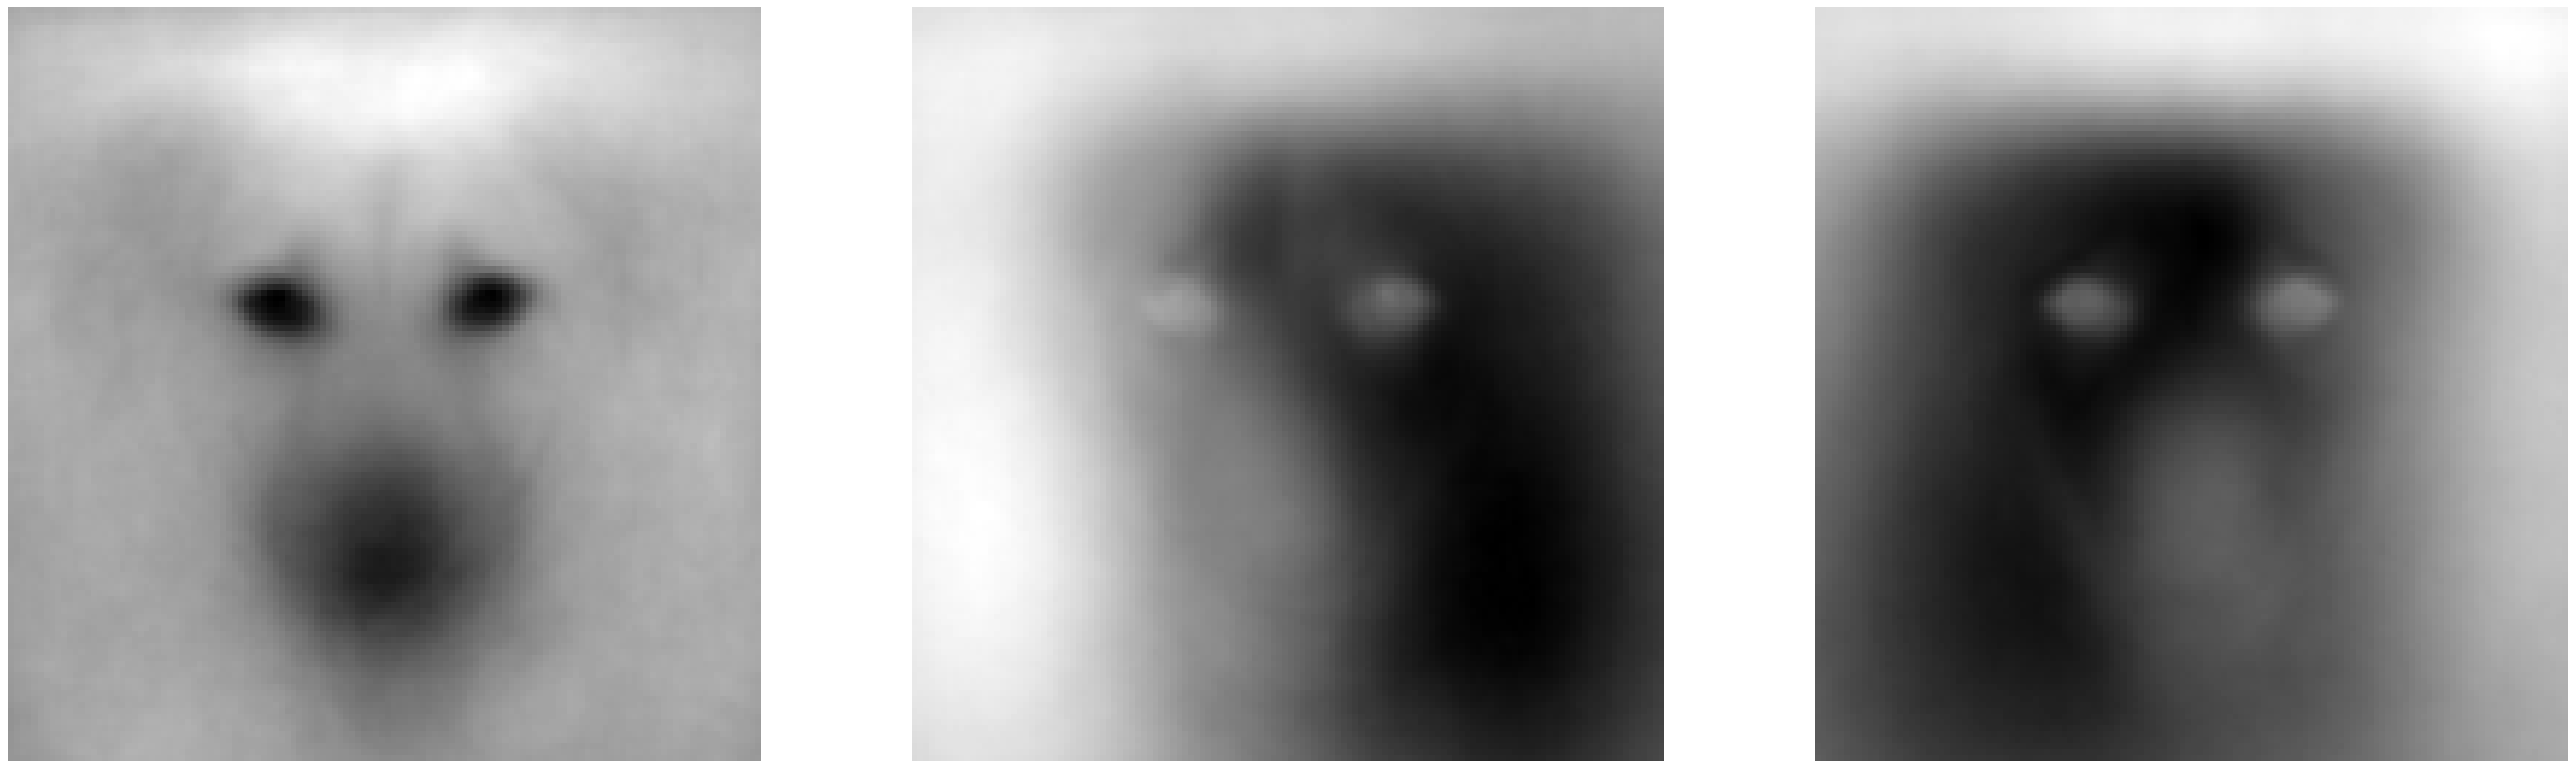

Some pets in eigenpets space: 


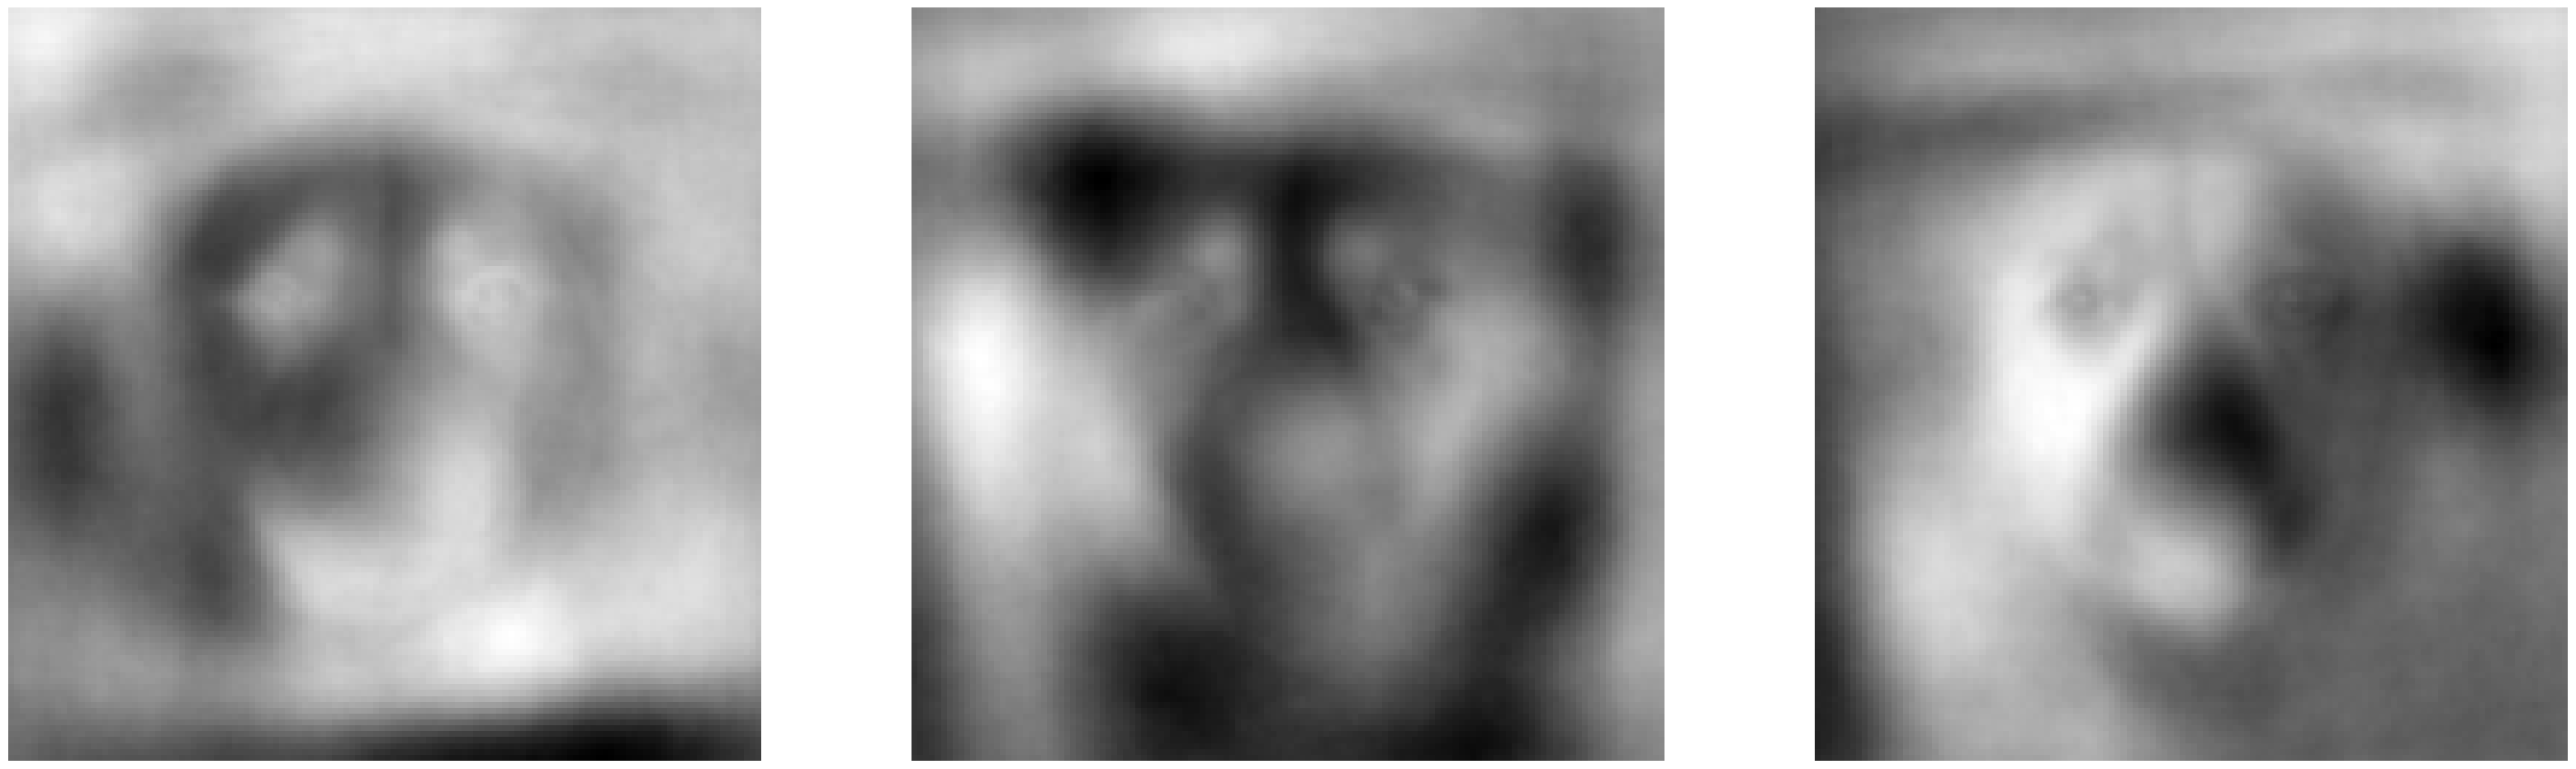

Original pets: 


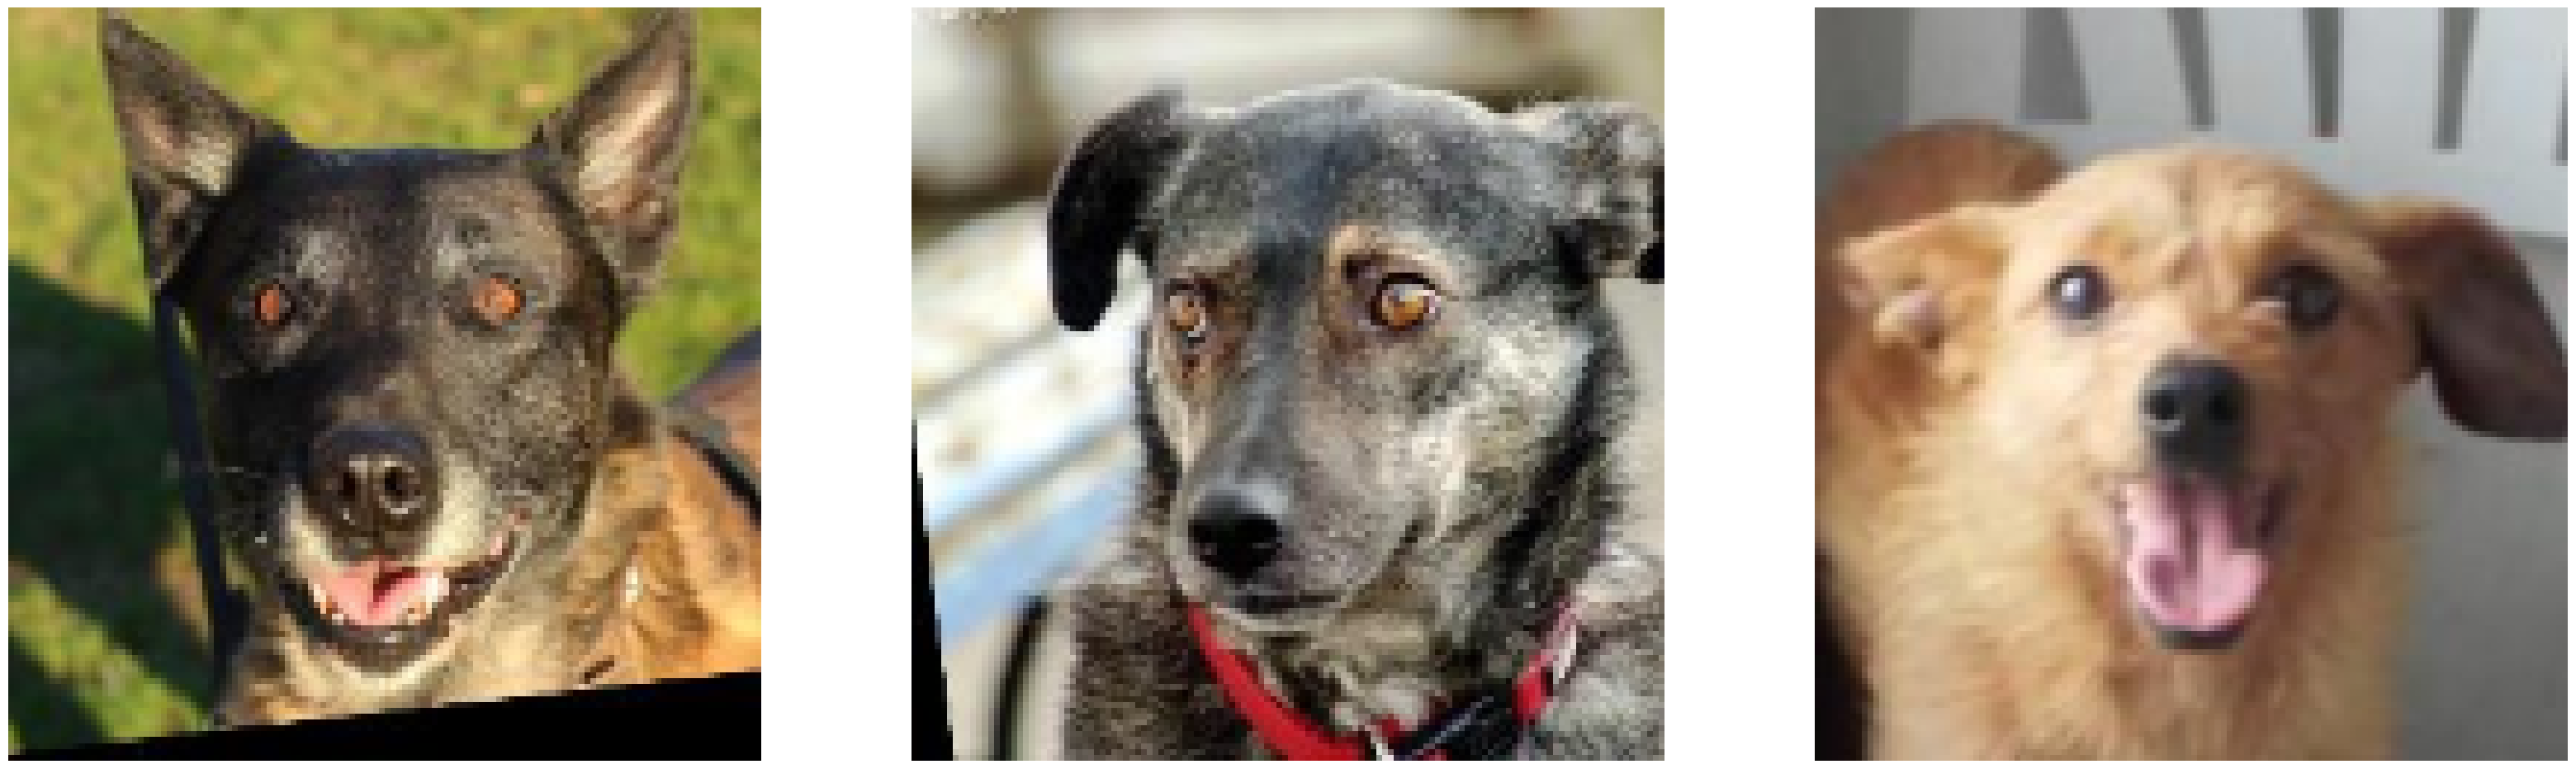

In [45]:
gray = np.array([rgb2gray_img(img) for img in X_train])
gray = MinMaxScaler().fit_transform(gray.reshape(-1, 128*128))
pca = PCA(n_components=0.8).fit(gray.reshape(gray.shape[0], -1))
# Assume pca is your fitted PCA model and h, w are the original image dimensions
eigenfaces = pca.components_.reshape((-1, 128, 128))
fig = plt.figure(figsize=(40, 40))
print(eigenfaces.shape)
# Visualize the first few eigenfaces

print(f"Some eigenpets: ")
for i, img in enumerate(eigenfaces[0:3]):
    fig.add_subplot(1, 3, i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.show()

weights = pca.transform(gray.reshape(gray.shape[0], -1))


kinda_original_img = pca.inverse_transform(weights).reshape(-1, 128, 128)

# other way
kinda_original_img = np.dot(weights, pca.components_).reshape(-1, 128, 128)


fig = plt.figure(figsize=(40, 40))


print(f"Some pets in eigenpets space: ")
for i, img in enumerate(kinda_original_img[0:3]):

    fig.add_subplot(1, 3, i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.show()

fig = plt.figure(figsize=(40, 40))


print(f"Original pets: ")
for i, img in enumerate(X_train[0:3]):

    fig.add_subplot(1, 3, i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.show()



In [20]:
def print_shape(X):
    print(X.shape)
    return X

In [21]:
eigen_pets = make_pipeline(
    DataTransformer(flatten),
    StandardScaler(),
    PCA(n_components=0.8)
)

In [22]:
gray_feat_pipe = make_pipeline(
    DataTransformer(rgb2gray_img),
    ConcatTransformer([
        Desc_transformer([
            hog_descriptor,
            lbp_descriptor,
            lambda d: compute_phog(d, 16)

        ]),
        eigen_pets
    ])
)

In [23]:
color_feat_pipe = Desc_transformer([
    color_histogram,
    # color_layout_descriptor
])

# KNN


In [30]:

main_pipe = make_pipeline(
    
    ConcatTransformer(
        pipes = (
            color_feat_pipe,
            gray_feat_pipe, 
        ),
        keep_original=False,
     ),

    DataTransformer(flatten),
    MinMaxScaler(),

    MLPClassifier(hidden_layer_sizes=(100, 10), max_iter=1000, verbose=True, warm_start=True, learning_rate_init=1e-5),
    

    verbose=True

)

main_pipe.fit(X_train, train_df["label"])
y_pred = main_pipe.predict(X_test)
print(classification_report(test_df["label"], y_pred))




[Pipeline] . (step 1 of 4) Processing concattransformer, total=16.3min
[Pipeline] ... (step 2 of 4) Processing datatransformer, total=   1.7s
[Pipeline] ...... (step 3 of 4) Processing minmaxscaler, total=   1.6s
Iteration 1, loss = 7.09650761
Iteration 2, loss = 7.09442664
Iteration 3, loss = 7.09355855
Iteration 4, loss = 7.09281319
Iteration 5, loss = 7.09137442
Iteration 6, loss = 7.09058539
Iteration 7, loss = 7.08836501
Iteration 8, loss = 7.08702232
Iteration 9, loss = 7.08552187
Iteration 10, loss = 7.08412232
Iteration 11, loss = 7.08269945
Iteration 12, loss = 7.08057896
Iteration 13, loss = 7.07900312
Iteration 14, loss = 7.07588635
Iteration 15, loss = 7.07405694
Iteration 16, loss = 7.07255708
Iteration 17, loss = 7.06999702
Iteration 18, loss = 7.06735296
Iteration 19, loss = 7.06512578
Iteration 20, loss = 7.06289063
Iteration 21, loss = 7.06061467
Iteration 22, loss = 7.05797468
Iteration 23, loss = 7.05508711
Iteration 24, loss = 7.05245254
Iteration 25, loss = 7.05118

d:\Users\Pablo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
         100       0.00      0.00      0.00         2
        1000       0.00      0.00      0.00         1
        1001       0.00      0.00      0.00         1
        1002       0.00      0.00      0.00         1
        1003       0.00      0.00      0.00         1
        1004       0.00      0.00      0.00         1
        1005       0.00      0.00      0.00         1
        1006       0.00      0.00      0.00         1
        1007       0.00      0.00      0.00         1
        1008       0.00      0.00      0.00         1
        1009       0.00      0.00      0.00         1
         101       0.17      0.50      0.25         2
        1010       0.00      0.00      0.00         1
        1011       0.00      0.00      0.00         1
        1012       0.00      0.00      0.00         1
        1013       0.00    

d:\Users\Pablo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Users\Pablo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Users\Pablo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [31]:
main_pipe.fit(X_train, train_df["label"])
y_pred = main_pipe.predict(X_test)
print(classification_report(test_df["label"], y_pred))

[Pipeline] . (step 1 of 4) Processing concattransformer, total=22.2min
[Pipeline] ... (step 2 of 4) Processing datatransformer, total=   2.0s
[Pipeline] ...... (step 3 of 4) Processing minmaxscaler, total=   2.0s
Iteration 1, loss = 3.70527347
Iteration 2, loss = 3.69984360
Iteration 3, loss = 3.69782120
Iteration 4, loss = 3.69501587
Iteration 5, loss = 3.69378475
Iteration 6, loss = 3.69277928
Iteration 7, loss = 3.69070711
Iteration 8, loss = 3.68867677
Iteration 9, loss = 3.68651973
Iteration 10, loss = 3.68590723
Iteration 11, loss = 3.68320059
Iteration 12, loss = 3.68173312
Iteration 13, loss = 3.67946555
Iteration 14, loss = 3.67867680
Iteration 15, loss = 3.67677508
Iteration 16, loss = 3.67491625
Iteration 17, loss = 3.67357707
Iteration 18, loss = 3.67214273
Iteration 19, loss = 3.66946200
Iteration 20, loss = 3.66745270
Iteration 21, loss = 3.66545098
Iteration 22, loss = 3.66631953
Iteration 23, loss = 3.66525088
Iteration 24, loss = 3.66100276
Iteration 25, loss = 3.65956

d:\Users\Pablo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
         100       0.00      0.00      0.00         2
        1000       1.00      1.00      1.00         1
        1001       0.00      0.00      0.00         1
        1002       1.00      1.00      1.00         1
        1003       0.00      0.00      0.00         1
        1004       0.00      0.00      0.00         1
        1005       0.00      0.00      0.00         1
        1006       0.00      0.00      0.00         1
        1007       0.00      0.00      0.00         1
        1008       0.00      0.00      0.00         1
        1009       0.00      0.00      0.00         1
         101       0.00      0.00      0.00         2
        1010       1.00      1.00      1.00         1
        1011       0.00      0.00      0.00         1
        1012       0.00      0.00      0.00         1
        1013       0.00    

d:\Users\Pablo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Users\Pablo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Users\Pablo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [23]:
X_train[0:10].shape

(10, 128, 128, 3)

In [24]:
X_train[0:10].reshape(10, -1).shape

(10, 49152)

In [25]:
print(y_pred == test_df["label"])

4792    False
6070    False
1804    False
7657    False
4577    False
        ...  
3169    False
8354    False
4018    False
8281    False
5408    False
Name: label, Length: 1572, dtype: bool


In [26]:
full_pipe = make_pipeline(
    load_pipe,
    
    KNeighborsClassifier(n_neighbors=7),
    verbose = True
)

# Transfer learning?

In [51]:
import torch

In [32]:
import tensorflow as tf

model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(128, 128, 3),
    pooling='avg',
    classes=df["label"].nunique(),
    classifier_activation='softmax',
)

model.trainable = False


feature_extractor = tf.keras.Model(
    inputs=model.inputs,
    outputs=model.layers[-2].output,

)

train = feature_extractor.predict(X_train)
train = train.reshape(train.shape[0], -1)

test = feature_extractor.predict(X_test)
test = test.reshape(test.shape[0], -1)



197/197 ━━━━━━━━━━━━━━━━━━━━ 466s 2s/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step


In [33]:

model = make_pipeline(
    MinMaxScaler(),
    KNeighborsClassifier(n_neighbors=1, metric='cosine'),
    verbose = True

)

model.fit(train, train_df["label"])

y_pred = model.predict(test)


print(classification_report(test_df["label"], y_pred))

[Pipeline] ...... (step 1 of 2) Processing minmaxscaler, total=   1.9s
[Pipeline]  (step 2 of 2) Processing kneighborsclassifier, total=   0.4s
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
         100       1.00      0.50      0.67         2
        1000       0.00      0.00      0.00         1
        1001       0.50      1.00      0.67         1
        1002       1.00      1.00      1.00         1
        1003       0.00      0.00      0.00         1
        1004       0.00      0.00      0.00         1
        1005       1.00      0.50      0.67         2
        1006       1.00      1.00      1.00         1
        1007       0.00      0.00      0.00         1
        1008       0.50      1.00      0.67         1
        1009       1.00      1.00      1.00         1
         101       0.50      0.50      0.50         2
        1010       1.00      1.00      1.00  

d:\Users\Pablo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Users\Pablo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Users\Pablo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Converting labels to one-hot encoding
# Encode labels into a range from 0 to number of classes - 1
le = LabelEncoder()
train_labels_encoded = le.fit_transform(train_df['label'])
test_labels_encoded = le.transform(test_df['label'])


# Convert labels to one-hot encoding
train_labels = to_categorical(train_labels_encoded)
test_labels = to_categorical(test_labels_encoded)

# Transfer Learning? Resnet50

In [41]:




model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(128, 128, 3),
    pooling='avg'
)
model.trainable = False

# Add a new dense layer for your classes
output_layer = tf.keras.layers.Dense(df["label"].nunique(), activation='softmax')(model.output)

# Create a new model
new_model = tf.keras.Model(model.input, output_layer)
new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
new_model.fit(X_train, train_labels, epochs=10, validation_data=(X_test, test_labels))


Epoch 1/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 644s 3s/step - accuracy: 0.0878 - loss: 8.4290 - val_accuracy: 0.3823 - val_loss: 3.3471
Epoch 2/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 599s 3s/step - accuracy: 0.8256 - loss: 0.7563 - val_accuracy: 0.5248 - val_loss: 2.4845
Epoch 3/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 678s 3s/step - accuracy: 0.9603 - loss: 0.1730 - val_accuracy: 0.6120 - val_loss: 2.0140
Epoch 4/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 624s 3s/step - accuracy: 0.9931 - loss: 0.0517 - val_accuracy: 0.6317 - val_loss: 1.8876
Epoch 5/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 605s 3s/step - accuracy: 0.9985 - loss: 0.0177 - val_accuracy: 0.6533 - val_loss: 1.7830
Epoch 6/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 710s 4s/step - accuracy: 0.9991 - loss: 0.0129 - val_accuracy: 0.6533 - val_loss: 1.8031
Epoch 7/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 573s 3s/step - accuracy: 0.9970 - loss: 0.0171 - val_accuracy: 0.6559 - val_loss: 1.7717
Epoch 8/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 538s 3s/step - accuracy: 0.9992 - loss: 0.0061 - val_accu

In [ ]:
import json

# Assume `history` is the returned object from model.fit()
history_dict = history.history

# Save it under 'history.json'
with open('history.json', 'w') as f:
    json.dump(history_dict, f)

# Later on, to load the history:
with open('history.json', 'r') as f:
    loaded_history_dict = json.load(f)


In [44]:
# Saving the model
new_model.save('tindog-resnet-softmax-1.0.0.keras')

# Fine tuning?

In [ ]:
from tensorflow.keras.layers import Dropout 

from tensorflow.keras.callbacks import ModelCheckpoint

# For initial training
checkpoint_path_initial = "training/initial/cp-{epoch:04d}.ckpt"
cp_callback_initial = ModelCheckpoint(
    filepath=checkpoint_path_initial, 
    verbose=1, 
    save_weights_only=True,
    period=1
)

# For fine-tuning
checkpoint_path_fine_tune = "training/fine_tune/cp-{epoch:04d}.ckpt"
cp_callback_fine_tune = ModelCheckpoint(
    filepath=checkpoint_path_fine_tune, 
    verbose=1, 
    save_weights_only=True,
    period=1
)


# Create a new model
model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(128, 128, 3),
    pooling='avg'
)
model.trainable = False

# Add a dropout layer
dropout_layer = Dropout(0.5)(model.output)

# Add a new dense layer for your classes
output_layer = tf.keras.layers.Dense(df["label"].nunique(), activation='softmax')(dropout_layer)

# Create a new model
new_model = tf.keras.Model(model.input, output_layer)

new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'], )

# Train the model
history_initial = new_model.fit(X_train, train_labels, epochs=5, validation_data=(X_test, test_labels), callbacks=[cp_callback_initial])

# Fine-tune some layers
for layer in model.layers[-20:]:
    layer.trainable = True

# Continue training
new_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
history_fine_tune = new_model.fit(X_train, train_labels, epochs=5, validation_data=(X_test, test_labels), callbacks=[cp_callback_fine_tune])

In [ ]:
# Saving history data
import json

history_dict = {
    'tindog-resnet-softmax-1.1.0': (history_initial.history, history_fine_tune.history)
}

# Save it under 'history.json'
with open('history.json', 'w') as f:
    json.dump(history_dict, f)


# Cross-validation?

In [ ]:
from sklearn.model_selection import KFold
from tensorflow.keras.layers import Dropout

# Number of splits
n_splits = 5

# Create a KFold object
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Convert labels to numpy array for indexing
labels = np.array(train_labels)

# Initialize results
results = []

# Loop over the folds
for train_index, val_index in kf.split(labels):
    # Split the data
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = labels[train_index], labels[val_index]

    # Create a new model
    model = tf.keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(128, 128, 3),
        pooling='avg'
    )
    model.trainable = False

    # Add a dropout layer
    dropout_layer = Dropout(0.5)(model.output)

    # Add a new dense layer for your classes
    output_layer = tf.keras.layers.Dense(df["label"].nunique(), activation='softmax')(dropout_layer)

    # Create a new model
    new_model = tf.keras.Model(model.input, output_layer)
    
    new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history_initial = new_model.fit(X_train_fold, y_train_fold, epochs=5, validation_data=(X_val_fold, y_val_fold))

    # Fine-tune some layers
    for layer in model.layers[-20:]:
        layer.trainable = True

    # Continue training
    new_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    history_fine_tune = new_model.fit(X_train_fold, y_train_fold, epochs=5, validation_data=(X_val_fold, y_val_fold))

    # Append the final epoch's validation accuracy to the results list
    results.append((history_initial.history['val_accuracy'][-1] ,history_fine_tune.history['val_accuracy'][-1]))

# Print the mean and standard deviation of the results
print(f"Cross-Validation Accuracy: {np.mean(results):.2f} (+/- {np.std(results):.2f})")


Normalization?

In [50]:
a = np.array([
    [1, 2, 10],
    [4, 6, 9],
])

print(MinMaxScaler().fit_transform(a))

[[0.5        0.         1.        ]
 [1.         1.         0.91666667]
 [0.         0.         0.        ]]
